### Research & Information Bank

Full OCR Implementations
- https://github.com/Breta01/handwriting-ocr/tree/master/notebooks

Simple OCRs
- https://github.com/OlehOnyshchak/OCR
- https://github.com/chungkwong/mathocr-myscript
- https://github.com/DexterLei/Math-OCR

Others
- https://github.com/dkurman/handwriting_recognition/blob/develop/src/text_body_detection/notebooks/MaskRCNN.ipynb
- https://github.com/Glyphoid/math-handwriting-lib

Annotator
- https://github.com/scalabel/scalabel

### Source:  Breta01/handwriting-ocr 

Command to execute in terminal
- git clone https://github.com/Breta01/handwriting-ocr.git
- conda create --name ocr-env
- conda activate ocr-env
- install Numpy (1.13), Tensorflow (1.4), OpenCV (3.1), Pandas (0.21), Matplotlib (2.1)
    - conda install tensorflow-gpu
    - conda install -c conda-forge matplotlib
- jupyter notebook

#### word detection

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

sys.path.append('../src')
from ocr.helpers import implt, resize, ratio
from ocr import page

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)

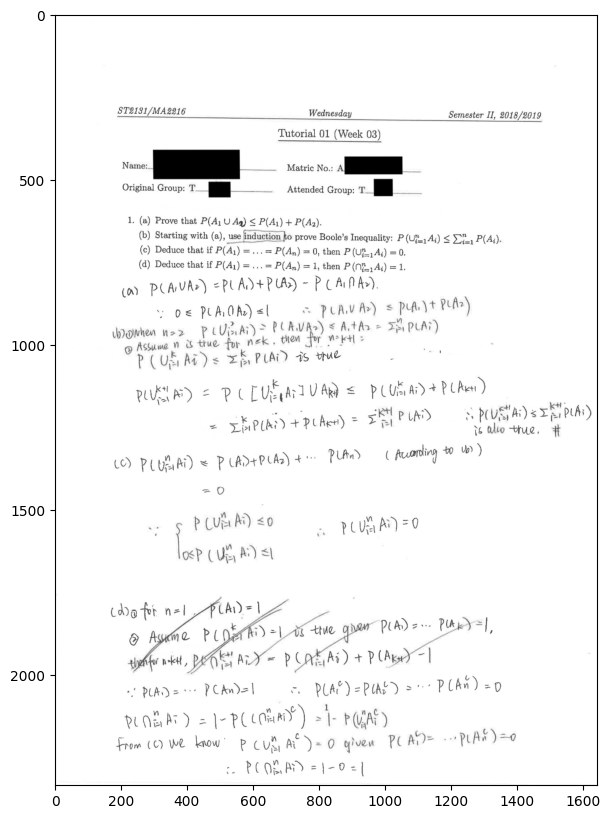

In [5]:
img = "page10"
# loading image (converting to RGB)
image = cv2.cvtColor(cv2.imread("C:\\Users\\20jam\\Documents\\always-in-progress\\DSA3101 Data Science in Practice\\project - personal attempts\\2. modified-data\\%s.jpg" % img), cv2.COLOR_BGR2RGB)
image = page.detection(image)
img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
implt(img, 'gray')

In [6]:
def sobel(channel):
    """ The Sobel Operator"""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    # Combine x, y gradient magnitudes sqrt(x^2 + y^2)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)


def edge_detect(im):
    """ 
    Edge detection 
    The Sobel operator is applied for each image layer (RGB)
    """
    return np.max(np.array([sobel(im[:,:, 0]), sobel(im[:,:, 1]), sobel(im[:,:, 2]) ]), axis=0)

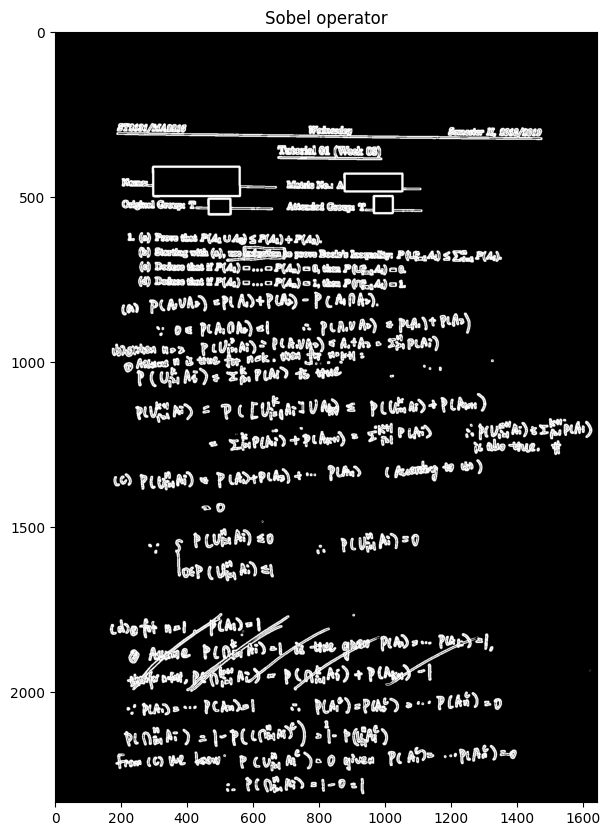

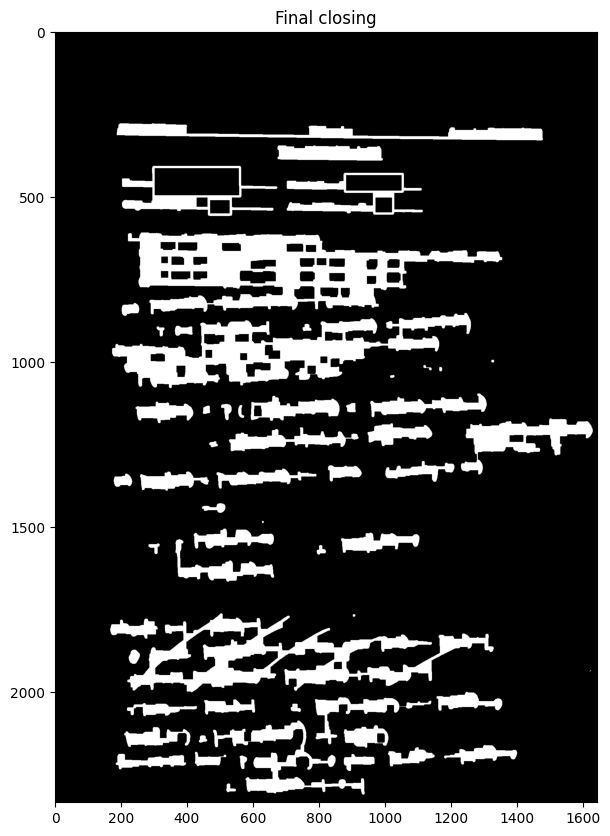

In [7]:
# image pre-processing - blur, edges, threshold, closing
blurred = cv2.GaussianBlur(image, (5, 5), 18)
edges = edge_detect(blurred)
ret, edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)
bw_image = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((20,20), np.uint8))

implt(edges, 'gray', 'Sobel operator')
implt(bw_image, 'gray', 'Final closing')

In [18]:
def textDetectWatershed(thresh, original):
    """ Text detection using watershed algorithm """
    # According to: http://docs.opencv.org/trunk/d3/db4/tutorial_py_watershed.html
    img = resize(original, 3000)
    thresh = resize(thresh, 3000)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
    
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.01*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers += 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0
    
    markers = cv2.watershed(img, markers)
    implt(markers, t='Markers')
    image = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Creating result array
    boxes = []
    for mark in np.unique(markers):
        # mark == 0 --> background
        if mark == 0:
            continue

        # Draw it on mask and detect biggest contour
        mask = np.zeros(gray.shape, dtype="uint8")
        mask[markers == mark] = 255

        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
        c = max(cnts, key=cv2.contourArea)
        
        # Draw a bounding rectangle if it contains text
        x,y,w,h = cv2.boundingRect(c)
        cv2.drawContours(mask, c, 0, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text
        if r > 0.1 and 2000 > w > 15 and 1500 > h > 15:
            boxes += [[x, y, w, h]]
    
    # Group intersecting rectangles
    boxes = group_rectangles(boxes)
    bounding_boxes = np.array([0,0,0,0])
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y),(x+w,y+h), (0, 255, 0), 8)
        bounding_boxes = np.vstack((bounding_boxes, np.array([x, y, x+w, y+h])))
        
    implt(image)

    # Recalculate coordinates to original size
    boxes = bounding_boxes.dot(ratio(original, img.shape[0])).astype(np.int64)
    return boxes[1:]  

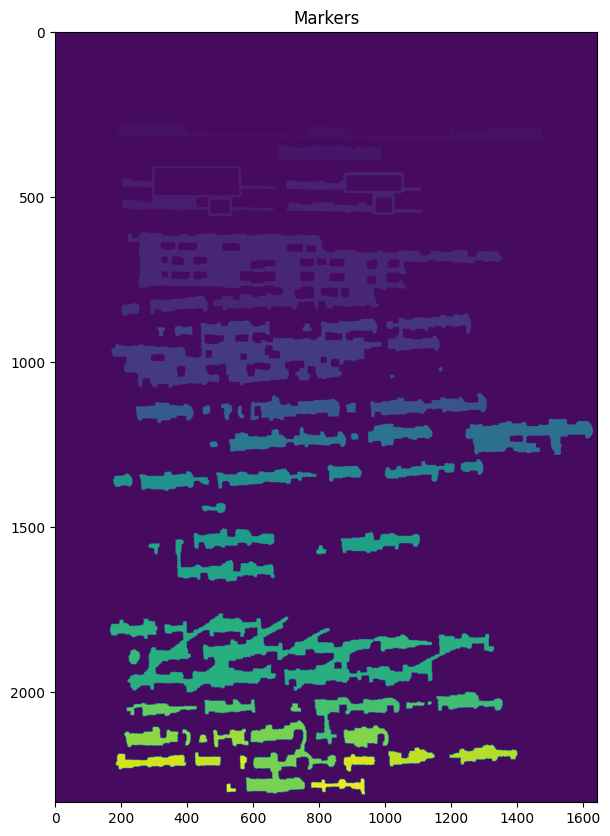

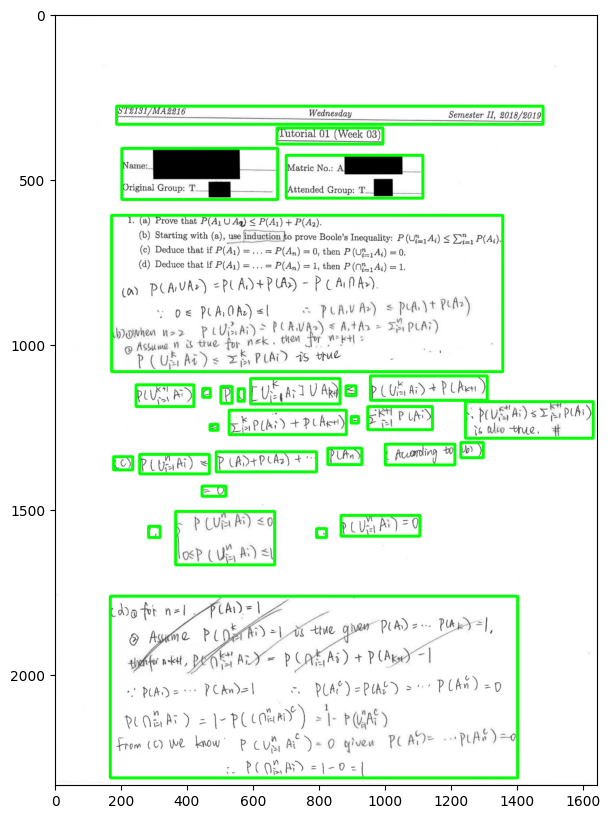

Number of boxes: 29


In [19]:
boxes = textDetectWatershed(bw_image, image)
print("Number of boxes:", len(boxes))

#### OCR

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

sys.path.append('../src')
from ocr.normalization import word_normalization, letter_normalization
from ocr import page, words, characters
from ocr.helpers import implt, resize
from ocr.tfhelpers import Model
from ocr.datahelpers import idx2char

Instructions for updating:
non-resource variables are not supported in the long term
Loading segmentation models...
INFO:tensorflow:Restoring parameters from c:\Users\20jam\Documents\GitHub\handwriting-ocr\src\ocr\..\..\models\gap-clas\CNN-CG
INFO:tensorflow:Restoring parameters from c:\Users\20jam\Documents\GitHub\handwriting-ocr\src\ocr\..\..\models\gap-clas\RNN\Bi-RNN-new


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)

In [3]:
IMG = 'C:\\Users\\20jam\\Documents\\always-in-progress\\DSA3101 Data Science in Practice\\project - personal attempts\\2. modified-data\\page42.jpg'
LANG = 'en'
# You can use only one of these two
# You HABE TO train the CTC model by yourself using word_classifier_CTC.ipynb
MODEL_LOC_CHARS = '../models/char-clas/' + LANG + '/CharClassifier'
MODEL_LOC_CTC = '../models/word-clas/CTC/Classifier1'

In [4]:
CHARACTER_MODEL = Model(MODEL_LOC_CHARS)
CTC_MODEL = Model(MODEL_LOC_CTC, 'word_prediction')

INFO:tensorflow:Restoring parameters from ../models/char-clas/en/CharClassifier
INFO:tensorflow:Restoring parameters from ../models/word-clas/CTC/Classifier1


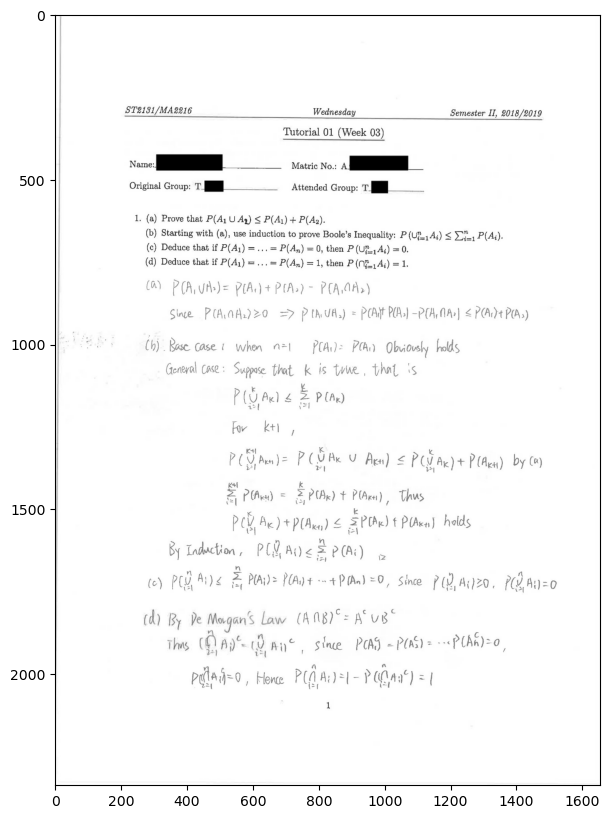

In [5]:
image = cv2.cvtColor(cv2.imread(IMG), cv2.COLOR_BGR2RGB)
implt(image)

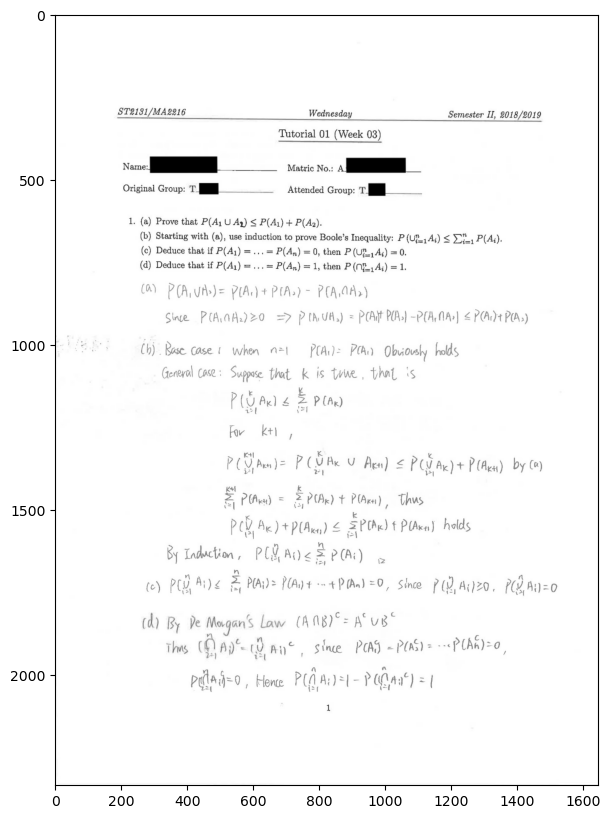

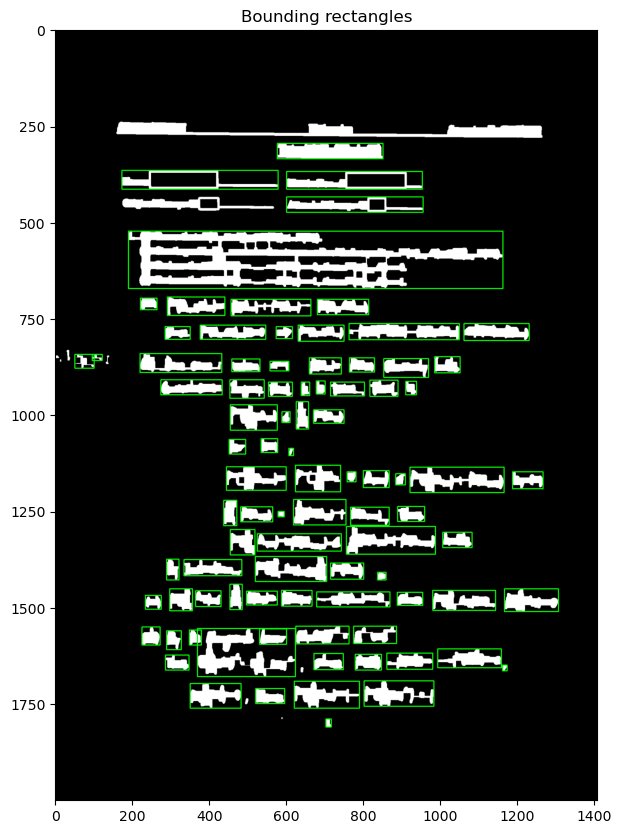

In [6]:
# Crop image and get bounding boxes
crop = page.detection(image)
implt(crop)
boxes = words.detection(crop)
lines = words.sort_words(boxes)

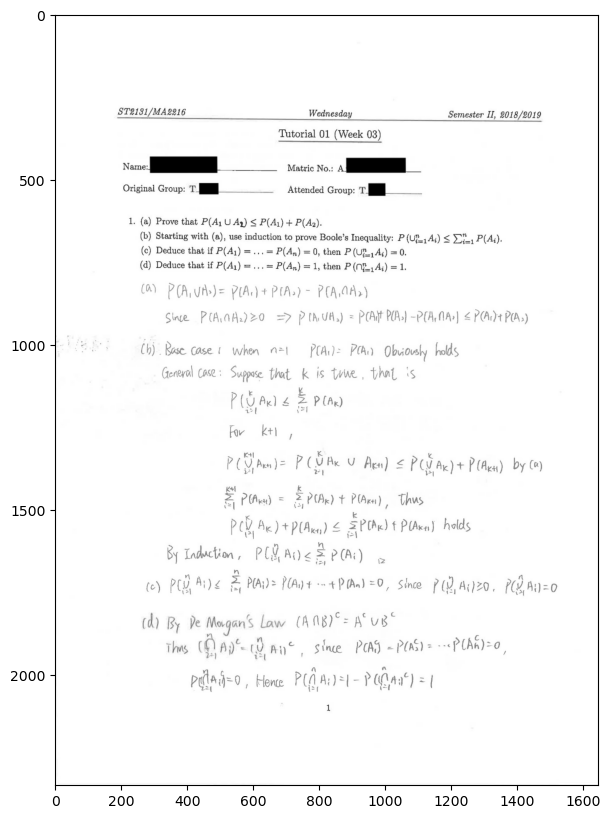

ZleSeSlScloelclol
eeeeee eeeeeeeee
rbeeTDeelcoeoOzpoe
zaaazZaaeaZacnaainuwsam
m Xmm qlfletmyljlez XgellGeJ
ouee elfhAdejs iy Xhrclelet vCfljeelhletiylftjftllet eelllelpylgy
nn uo Aksoccasev Elcen rsol qlhet rgD Aanltofl khlS
Acrehbrllirea wBec vhxrl h s wlpee fGgl s
qlSget s e glraj
w wt j
elyrhrz rlw cl Gaplj c elllrclvhlgxD ajlaj
g eCeexeel o ejcnr rbeevt Thrlrs
jAl datvjlguvtcc zelreteylud Geglcls
g ulbreuore PAlhteza eCfleJ z
o HG gete a welc qlgejoe moefglrozB oerce eRMdea Adgetco
All g jc mnm teuv lYASjcc dcod
phne oenee PlHg vlrez melrrlco j
ydlapjaP fdapee MGetaz Mjlpqetem
l


In [7]:
def recognise(img):
    """Recognition using character model"""
    # Pre-processing the word
    img = word_normalization(
        img,
        60,
        border=False,
        tilt=True,
        hyst_norm=True)

    # Separate letters
    img = cv2.copyMakeBorder(
        img,
        0, 0, 30, 30,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0])
    gaps = characters.segment(img, RNN=True)

    chars = []
    for i in range(len(gaps)-1):
        char = img[:, gaps[i]:gaps[i+1]]
        char, dim = letter_normalization(char, is_thresh=True, dim=True)
        # TODO Test different values
        if dim[0] > 4 and dim[1] > 4:
            chars.append(char.flatten())

    chars = np.array(chars)
    word = ''        
    if len(chars) != 0:
        pred = CHARACTER_MODEL.run(chars)                
        for c in pred:
            word += idx2char(c)

    return word

implt(crop)
for line in lines:
    print(" ".join([recognise(crop[y1:y2, x1:x2]) for (x1, y1, x2, y2) in line]))